In [1]:
import numpy as np

In [9]:
from tqdm import tqdm as tqdm

In [10]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def blr(y, F, mu_0, Sigma_0, a_0, b_0, n_draws=1):
    n = y.shape[0]
    p = mu_0.shape[0]
    mu_post = np.matmul(np.linalg.inv(np.matmul(np.transpose(F), F) + Sigma_0),
                        np.matmul(Sigma_0, mu_0) + np.matmul(np.transpose(F), y))
    Sigma_post = np.matmul(np.transpose(F), F) + Sigma_0
    a_post = a_0 + n / 2
    b_post = b_0 + 0.5 * (np.matmul(np.transpose(y), y) + 
                          np.matmul(np.matmul(np.transpose(mu_0), Sigma_0), mu_0) - 
                          np.matmul(np.matmul(np.transpose(mu_post), Sigma_post), mu_post))
    beta = np.empty([n_draws, p])
    sigma2_eps = 1 / np.random.gamma(a_post, 1 / b_post, n_draws)
    
    for i in range(n_draws):
        beta[i, :] = np.random.multivariate_normal(mu_post, sigma2_eps[i] * np.linalg.inv(Sigma_post))
    return beta, sigma2_eps


def blr_mv(y, F, mu_0, Sigma_0, a_0, b_0):
    q = y.shape[1]
    r = F.shape[1]
    beta_est = np.empty([r, q])
    sigma2_eps_est = np.empty(q)
    for j in range(q):
        results = blr(y[:, j], F, mu_0, Sigma_0, a_0, b_0)
        beta_est[:, j] = results[0]
        sigma2_eps_est[j] = results[1]
    return beta_est, sigma2_eps_est


def sample_regression_posterior(Y, F, loading_prior_params=[0, 1], variance_prior_params=[1, 1]):
    r = F.shape[1]
    mu_0 = np.repeat(loading_prior_params[0], r)  # prior for regression coefficients
    Sigma_0 = np.diag(np.repeat(loading_prior_params[1], r)) 
    loading, variance = blr_mv(Y, F, mu_0, Sigma_0, variance_prior_params[0], variance_prior_params[1])
    return loading, variance

In [3]:
def build_covariance_blocks(F_covariance_list, loading_matrix, Y_variance):
    """
    Build covariance matrix for long vector of all columns of Y stacked together.
    
    Args
        F_covariance_list: (list) of [t, t] covariance matrices
        loading_matrix: (numpy array) [r, q] linear transformation between F and Y
        Y_sigma_list: (numpy array) [q] variance parameters for columns of Y
    """
    r = len(F_covariance_list)
    t = F_covariance_list[0].shape[0]
    q = loading_matrix.shape[1]
    block_YY = np.zeros((q * t, q * t))
    # covariance for columns of F
    block_FF_rows = []
    for i in range(r):
        current_row = np.zeros((t, r * t))
        current_row[:, (i * t):(i * t + t)] = F_covariance_list[i]
        block_FF_rows.append(current_row)
    block_FF = np.vstack(block_FF_rows)
    # covariance between columns of F and columns of Y
    block_FY_rows = []
    for i in range(r):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            current_row[:, (j * t):(j * t + t)] = loading_matrix[i, j] * F_covariance_list[i]
        block_FY_rows.append(current_row)
    block_FY = np.vstack(block_FY_rows)
    block_YF = np.transpose(block_FY)
    # covariance between columns of Y
    block_YY_rows = []
    for i in range(q):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            for k in range(r):
                current_row[:, (j * t):(j * t + t)] += F_covariance_list[k] * loading_matrix[k, i] * loading_matrix[k, j]
            if i == j:
                current_row[:, (j * t):(j * t + t)] += np.eye(t) * Y_variance[i]  # diagonal variance
        block_YY_rows.append(current_row)
    block_YY = np.vstack(block_YY_rows)
    return block_FF, block_FY, block_YF, block_YY


def sample_conditional_F(Y, blocks, debug=False):
    """
    Sample from conditional distribution of F given everything else.
    
    Args
        Y: (numpy array) [t, q] observed multivariate time series
        block_FF, block_FY, block_YF, block_YY: (numpy array) blocks in the covariance of joint distribution
    """
    block_FF, block_FY, block_YF, block_YY = blocks
    t, q = Y.shape
    r = int(block_FF.shape[0] / t)
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    block_YY_inverse = np.linalg.inv(block_YY)
    prod = np.matmul(block_FY, block_YY_inverse)
    mu = np.matmul(prod, Y_stack)
    covariance = block_FF - np.matmul(prod, block_YF)
    F_stack = np.random.multivariate_normal(mu, covariance)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    if debug:
        return F_sample, covariance
    else:
        return F_sample

In [4]:
from scipy.stats import gamma, cauchy, multivariate_normal, norm

In [5]:
def l_gamma_prior(l, a, b):
    """
    Gamma prior on length scale
    """
    return gamma.pdf(l, a=a, scale=1/b)


def s_half_cauchy_prior(s, scale):
    return 2 * cauchy.pdf(s, loc=0, scale=scale)


def kernel_covariance(x, l, s, noise=1e-6):
    """
    Covariance matrix with squared exponential kernel
    """
    t = x.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * np.exp(-(x[i] - x[j]) ** 2 / (2 * l ** 2))
    cov_sample += np.eye(t) * noise  # add noise for numerical stability
    return cov_sample


def reshape_latent_curves(F, n, t):
    """
    Turn latent factors F of shape [nt, r] into a list of r factors of shape [t, n]
    """
    r = F.shape[1]
    F_curves_list = []
    for j in range(r):
        F_curves = np.zeros((t, n))
        for i in range(n):
            F_curves[:, i] = F[(i * t):(i * t + t), j]
        F_curves_list.append(F_curves)
    return F_curves_list

In [89]:
def accept_reject(accept_prob):
    u = np.random.uniform(low=0.0, high=1.0, size=1)
    return u < accept_prob


def gp_marginal_likelihood(y, x, l, s):
    """
    Marginal likelihood of one Gaussian process (multivariate Normal)
    """
    t = y.shape[0]
    mu = np.repeat(0, t)
    cov = kernel_covariance(x, l, s)
    return multivariate_normal.pdf(y, mu, cov)


def propose(current, std):
    value = -1
    while value < 0:
        value = np.random.normal(loc=current, scale=std, size=1)
    return value


def calculate_p(l, s, Y, x, prior_params):
    """
    Calculate log prior and likelihood of n independent Gaussian processes (Y has shape [t, n])
    """
    a, b, scale = prior_params
    prior = l_gamma_prior(l, a, b)  # * s_half_cauchy_prior(s, scale)
    loglik = 0.0
    for j in range(Y.shape[1]):
        loglik += np.log(gp_marginal_likelihood(Y[:, j], x, l, s))  # independent observations
    return np.log(prior) + loglik


def metropolis_update(l, s, p, Y, x, prior_params, proposal_scales):
    l_new = propose(l, proposal_scales[0])
    s_new = 1.0

    p_new = calculate_p(l_new, s_new, Y, x, prior_params)
    
    if accept_reject(np.exp(p_new - p)):
        return l_new, s_new, p_new
    else:
        return l, s, p


def metropolis_sample(n_iter, Y, x, prior_params, proposal_scales):
    # initial length scale proposal is centered at Gamma prior mean
    l = propose(prior_params[0] * prior_params[1], proposal_scales[0])
    s = 1.0
    p = calculate_p(l, s, Y, x, prior_params)
    
    l_trace = []
    s_trace = []
    for i in range(n_iter):
        l, s, p = metropolis_update(l, s, p, Y, x, prior_params, proposal_scales)
        l_trace.append(l)
        s_trace.append(s)
        
    return l_trace, s_trace

In [45]:
class FactorGP:
    """
    Latent factor Gaussian process model for multivariate time series 
    Data: n epochs, t time points, q dimensional, r latent factors
    Parameters: loading matrix (r x q), variance vector (q), length scale (r)
    Priors: Conjugate Normal, Inverse-Gamma, and Gamma (needs to be informative)
    """

    def __init__(self, dims, mu_var=[0, 1], inverse_gamma=[1, 1], gamma=[10, 1], F=None):
        n, t, q, r = dims
        self.dims = dims
        self.x = np.linspace(1, t, t)  # time points are indexed by intergers from 1 to t
        self.loading_prior_params = mu_var  # prior mean and variance for loading coeffcients
        self.variance_prior_params = inverse_gamma  # inverse Gamma prior for variance
        self.length_prior_params = gamma  # Gamma prior on length scale
        #self.kernel_type = 'default'
        self.loading, self.variance, self.theta = self.__initiate_params(dims, mu_var, inverse_gamma, gamma)
        self.F = F


    def __initiate_params(self, dims, mu_var, inverse_gamma, gamma):
        n, t, q, r = dims
        loading = np.random.normal(mu_var[0], np.sqrt(mu_var[1]), [r, q])
        variance = np.random.normal(0, 0.5, q) ** 2  # ad-hoc
        theta = np.repeat(gamma[0] * gamma[1], r)  # set length scale to gamma mean
        return loading, variance, theta


    def conditional_latent(self, Y):
        n, t, q, r = self.dims
        covs = []
        for l in self.theta:
            covs.append(kernel_covariance(self.x, l, 1.0))
        blocks = build_covariance_blocks(covs, self.loading, self.variance)
        F = np.zeros((n * t, r))
        # sample from F conditional distribution for each epoch independently
        for i in range(n):
            F[(i * t):(i * t + t), :] = sample_conditional_F(Y[(i * t):(i * t + t), :], blocks)
        self.F = F
    

    def predict(self):
        return np.matmul(self.F, self.loading)

In [90]:
def gibbs_update_params(Y, model, chain_size=50, proposal_std=0.5):
    """
    Sample from model parameter posterior given Y and F 
    
    Note: the model does not change at all
    """
    n, t, q, r = model.dims
    if model.F is None:
        model.conditional_latent(Y)
    F = model.F  # get current latent and condition on it for sampling
    loading, variance = sample_regression_posterior(Y, F, model.loading_prior_params, model.variance_prior_params)
    theta = np.zeros(r)
    traces = np.zeros((r, chain_size))
    F_curves_list = reshape_latent_curves(F, n, t)
    for i, F_curves in enumerate(F_curves_list):
        l_trace, s_trace = metropolis_sample(chain_size, F_curves, model.x, 
                                             prior_params=[model.length_prior_params[0], model.length_prior_params[1], 1.0], 
                                             proposal_scales=[proposal_std, proposal_std])
        theta[i] = l_trace[-1]
        traces[i, :] = l_trace
    return F, loading, variance, theta, traces

In [91]:
def run_gibbs(Y, model, n_steps, chain_size, proposal_std, verbose=False):
    """
    Run Metropolis with-in Gibbs sampler on latent factor GP model using data Y
    
    Args
        Y: (numpy array) of shape [nt, q] and contains n stacked epochs of [t, q]
        model: latent factor GP model
        n_steps: (int) number of steps
        chain_size: (int) size of Metropolis chain at each iteration
        proposal_std: (float) standard deviation of Metropolis proposal distribution
        verbose: (bool) whether or not to print out MSE and length scale (for sanity check)
    """
    n, t, q, r = model.dims
    
    F_sample = np.zeros((n_steps, n * t, r))
    loading_sample = np.zeros((n_steps, r, q))
    variance_sample = np.zeros((n_steps, q))
    theta_sample = np.zeros((n_steps, r))
    traces_hist = np.zeros((n_steps, r, chain_size))
    mse_history = np.zeros(n_steps)
    
    for i in tqdm(range(n_steps)):
        F, loading, variance, theta, traces = gibbs_update_params(Y, model, chain_size, proposal_std)
        # update model parameters and predict
        model.loading = loading
        model.variance = variance
        model.theta = theta
        Y_hat = model.predict()
        mse = np.mean((Y - Y_hat) ** 2)
        if verbose:
            print('Current MSE: {}'.format(mse))
            print('Current length scale: {}'.format(theta))
        # save everything
        F_sample[i, :, :] = F
        loading_sample[i, :, :] = loading 
        variance_sample[i, :] = variance
        theta_sample[i, :] = theta
        traces_hist[i, :, :] = traces
        mse_history[i] = mse
        # update model latent factors
        model.conditional_latent(Y)
    return F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [19]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=10))

In [20]:
x = np.linspace(1, 50, 50)
curves = gp.sample_y(x.reshape((50, 1)), 4)

In [173]:
F = np.zeros((100, 2))  # 2 epochs x 50 time points x 2 factors
for i in range(2):
    for j in range(2):
        F[(i * 50):(i * 50 + 50), j] = curves[:, (i * 2 + j)]

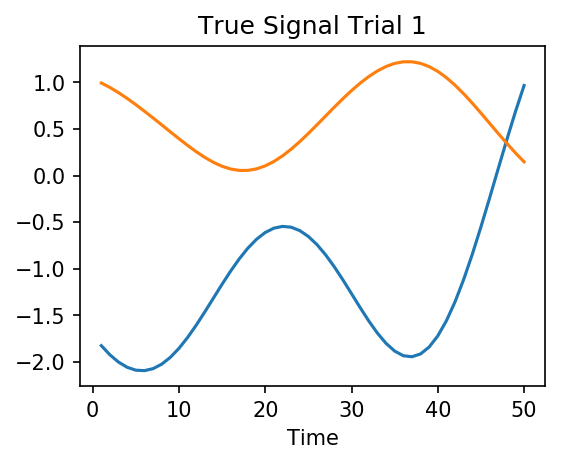

In [182]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(x, F[:50, j])
plt.title('True Signal Trial 1')
plt.xlabel('Time')
plt.show()

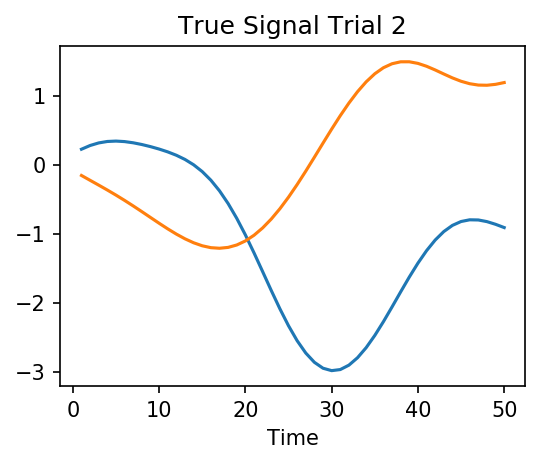

In [183]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(x, F[50:, j])
plt.title('True Signal Trial 2')
plt.xlabel('Time')
plt.show()

In [26]:
loading = np.random.normal(0, 1, [2, 6])
Y_true = np.matmul(F, loading)
Y = Y_true + np.random.normal(0, 0.5, [100, 6])

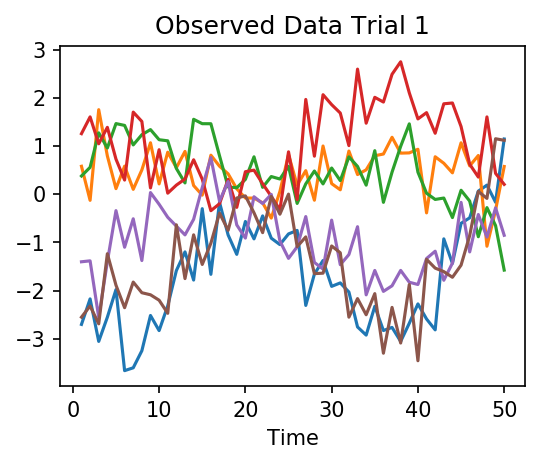

In [184]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(6):
    plt.plot(x, Y[:50, j])
plt.title('Observed Data Trial 1')
plt.xlabel('Time')
plt.show()

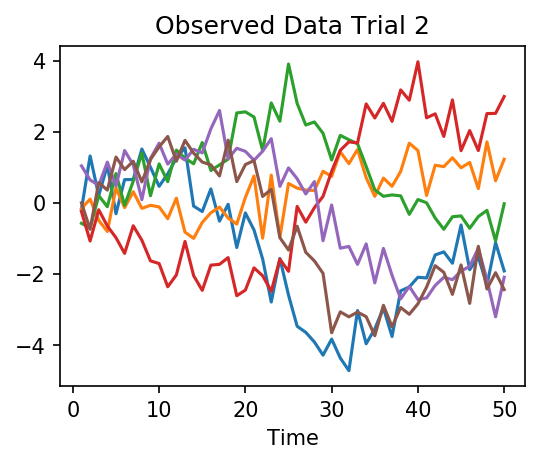

In [185]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(6):
    plt.plot(x, Y[50:, j])
plt.title('Observed Data Trial 2')
plt.xlabel('Time')
plt.show()

In [126]:
dims = [2, 50, 6, 2]  # n, t, q, r
model = FactorGP(dims)

In [127]:
model.conditional_latent(Y)

In [155]:
from sklearn.decomposition import PCA

In [156]:
latent_dim = 2
pca = PCA(n_components=latent_dim)
components = pca.fit_transform(Y)

In [157]:
Y_hat = pca.inverse_transform(components)
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.14378154383863537


In [158]:
print(components.shape)

(100, 2)


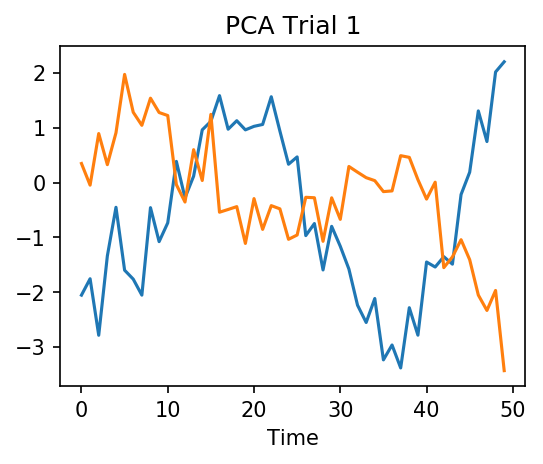

In [186]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[:50, j])
plt.title('PCA Trial 1')
plt.xlabel('Time')
plt.show()

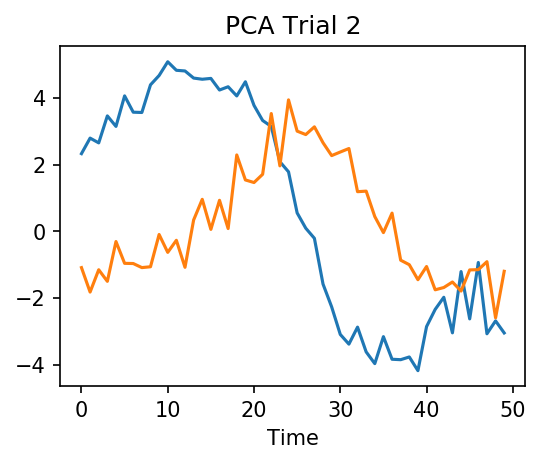

In [187]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[50:, j])
plt.title('PCA Trial 2')
plt.xlabel('Time')
plt.show()

In [133]:
results = run_gibbs(Y, model, 100, 50, 0.5, verbose=True)


  1%|          | 1/100 [00:04<06:44,  4.08s/it]

Current MSE: 0.265882638222
Current length scale: [9.39909454 9.62547269]



  2%|▏         | 2/100 [00:07<06:32,  4.01s/it]

Current MSE: 0.234155269253
Current length scale: [9.18862925 9.67581865]



  3%|▎         | 3/100 [00:12<06:35,  4.08s/it]

Current MSE: 0.221915344512
Current length scale: [ 9.63160044 10.16887311]



  4%|▍         | 4/100 [00:16<06:36,  4.13s/it]

Current MSE: 0.236399754912
Current length scale: [ 8.87480535 10.63629252]



  5%|▌         | 5/100 [00:21<06:46,  4.28s/it]

Current MSE: 0.22821938514
Current length scale: [ 8.68245289 10.59407678]



  6%|▌         | 6/100 [00:25<07:00,  4.47s/it]

Current MSE: 0.229687168822
Current length scale: [ 8.45192004 10.14998591]



  7%|▋         | 7/100 [00:30<07:07,  4.59s/it]

Current MSE: 0.236956921563
Current length scale: [ 8.51407924 10.27457057]



  8%|▊         | 8/100 [00:34<06:46,  4.42s/it]

Current MSE: 0.235741282279
Current length scale: [ 8.97199362 10.37024952]



  9%|▉         | 9/100 [00:38<06:26,  4.24s/it]

Current MSE: 0.235773374649
Current length scale: [8.53869181 9.70188551]



 10%|█         | 10/100 [00:42<06:11,  4.12s/it]

Current MSE: 0.234726958384
Current length scale: [8.7816127 9.1388966]



 11%|█         | 11/100 [00:46<06:05,  4.10s/it]

Current MSE: 0.234976984424
Current length scale: [8.85538361 9.34131237]



 12%|█▏        | 12/100 [00:50<06:08,  4.19s/it]

Current MSE: 0.238704163824
Current length scale: [8.57469981 9.76187372]



 13%|█▎        | 13/100 [00:55<06:13,  4.29s/it]

Current MSE: 0.228495063583
Current length scale: [8.56261388 9.6620589 ]



 14%|█▍        | 14/100 [00:59<05:59,  4.18s/it]

Current MSE: 0.22907733722
Current length scale: [8.88093389 9.23855825]



 15%|█▌        | 15/100 [01:03<05:57,  4.20s/it]

Current MSE: 0.232131207893
Current length scale: [9.32502382 9.27569621]



 16%|█▌        | 16/100 [01:08<05:57,  4.26s/it]

Current MSE: 0.228650078325
Current length scale: [9.54156716 9.27236774]



 17%|█▋        | 17/100 [01:12<05:49,  4.22s/it]

Current MSE: 0.226825603312
Current length scale: [9.63932021 9.6900672 ]



 18%|█▊        | 18/100 [01:16<05:36,  4.11s/it]

Current MSE: 0.225460389747
Current length scale: [9.51497853 9.58413582]



 19%|█▉        | 19/100 [01:19<05:26,  4.03s/it]

Current MSE: 0.22799298066
Current length scale: [9.39052148 9.97924021]



 20%|██        | 20/100 [01:23<05:18,  3.98s/it]

Current MSE: 0.227330077168
Current length scale: [9.77415902 9.41612436]



 21%|██        | 21/100 [01:27<05:15,  4.00s/it]

Current MSE: 0.228207364825
Current length scale: [9.74589409 9.89596891]



 22%|██▏       | 22/100 [01:31<05:08,  3.96s/it]

Current MSE: 0.228406301119
Current length scale: [10.01701594  9.63642605]



 23%|██▎       | 23/100 [01:35<05:02,  3.93s/it]

Current MSE: 0.231826298491
Current length scale: [10.57711948  9.941533  ]



 24%|██▍       | 24/100 [01:39<04:56,  3.90s/it]

Current MSE: 0.233844469605
Current length scale: [10.50343095  9.96238456]



 25%|██▌       | 25/100 [01:43<04:50,  3.88s/it]

Current MSE: 0.23705827244
Current length scale: [9.9826088  9.19549816]



 26%|██▌       | 26/100 [01:47<04:58,  4.04s/it]

Current MSE: 0.230036480844
Current length scale: [10.11188299  9.01121403]



 27%|██▋       | 27/100 [01:51<05:01,  4.13s/it]

Current MSE: 0.230376641825
Current length scale: [9.92383606 9.23320895]



 28%|██▊       | 28/100 [01:56<05:00,  4.17s/it]

Current MSE: 0.233515371545
Current length scale: [11.01820461  8.74494586]



 29%|██▉       | 29/100 [02:00<04:57,  4.19s/it]

Current MSE: 0.236401479358
Current length scale: [11.19324686  8.89311367]



 30%|███       | 30/100 [02:04<04:52,  4.19s/it]

Current MSE: 0.232031471655
Current length scale: [11.03119272  8.46040054]



 31%|███       | 31/100 [02:08<04:46,  4.15s/it]

Current MSE: 0.229336643517
Current length scale: [11.03129074  9.14942606]



 32%|███▏      | 32/100 [02:13<04:48,  4.24s/it]

Current MSE: 0.223769566688
Current length scale: [10.83360735 10.02352613]



 33%|███▎      | 33/100 [02:17<04:52,  4.36s/it]

Current MSE: 0.237838306666
Current length scale: [10.80989588 10.35108374]



 34%|███▍      | 34/100 [02:22<04:46,  4.34s/it]

Current MSE: 0.231751691014
Current length scale: [10.31101916  9.97625961]



 35%|███▌      | 35/100 [02:26<04:36,  4.25s/it]

Current MSE: 0.231159892198
Current length scale: [10.65071915  9.93754488]



 36%|███▌      | 36/100 [02:30<04:34,  4.30s/it]

Current MSE: 0.229822430583
Current length scale: [11.34434898 10.1117769 ]



 37%|███▋      | 37/100 [02:34<04:28,  4.26s/it]

Current MSE: 0.231707919723
Current length scale: [10.20098272  9.85151055]



 38%|███▊      | 38/100 [02:38<04:21,  4.22s/it]

Current MSE: 0.234641811347
Current length scale: [10.46111419  9.87462263]



 39%|███▉      | 39/100 [02:42<04:15,  4.19s/it]

Current MSE: 0.234999803149
Current length scale: [11.1427045   9.28634927]



 40%|████      | 40/100 [02:47<04:11,  4.19s/it]

Current MSE: 0.22984162832
Current length scale: [10.41633612  9.44447414]



 41%|████      | 41/100 [02:51<04:07,  4.19s/it]

Current MSE: 0.227996490492
Current length scale: [9.8413726  9.69089243]



 42%|████▏     | 42/100 [02:55<04:01,  4.16s/it]

Current MSE: 0.225311813917
Current length scale: [9.08650962 9.95172033]



 43%|████▎     | 43/100 [02:59<03:59,  4.19s/it]

Current MSE: 0.235811654461
Current length scale: [9.15765472 9.95707216]



 44%|████▍     | 44/100 [03:03<03:54,  4.19s/it]

Current MSE: 0.233871882376
Current length scale: [9.5164768  9.68176544]



 45%|████▌     | 45/100 [03:08<03:50,  4.19s/it]

Current MSE: 0.229801073686
Current length scale: [9.58733963 9.48661264]



 46%|████▌     | 46/100 [03:12<03:46,  4.20s/it]

Current MSE: 0.228488277074
Current length scale: [9.71316353 9.03695333]



 47%|████▋     | 47/100 [03:16<03:40,  4.17s/it]

Current MSE: 0.232900923533
Current length scale: [9.96015175 8.87786905]



 48%|████▊     | 48/100 [03:20<03:37,  4.18s/it]

Current MSE: 0.2381614393
Current length scale: [10.60987301  9.49447342]



 49%|████▉     | 49/100 [03:24<03:36,  4.25s/it]

Current MSE: 0.22840615923
Current length scale: [10.57632642  9.86878295]



 50%|█████     | 50/100 [03:29<03:33,  4.26s/it]

Current MSE: 0.228034508308
Current length scale: [10.2706713  10.09378346]



 51%|█████     | 51/100 [03:33<03:27,  4.24s/it]

Current MSE: 0.228493436668
Current length scale: [10.38790792  9.62704939]



 52%|█████▏    | 52/100 [03:37<03:22,  4.23s/it]

Current MSE: 0.228622005627
Current length scale: [10.04500386  9.82663045]



 53%|█████▎    | 53/100 [03:41<03:19,  4.25s/it]

Current MSE: 0.230834975088
Current length scale: [ 9.80488498 10.31369014]



 54%|█████▍    | 54/100 [03:46<03:13,  4.21s/it]

Current MSE: 0.236458131275
Current length scale: [ 9.68456225 11.19824976]



 55%|█████▌    | 55/100 [03:50<03:07,  4.16s/it]

Current MSE: 0.232787123044
Current length scale: [ 9.55741581 11.72341161]



 56%|█████▌    | 56/100 [03:54<03:02,  4.15s/it]

Current MSE: 0.236867646876
Current length scale: [ 9.68481005 11.96134722]



 57%|█████▋    | 57/100 [03:58<02:58,  4.16s/it]

Current MSE: 0.237779503756
Current length scale: [ 9.98721047 11.82934665]



 58%|█████▊    | 58/100 [04:02<02:54,  4.16s/it]

Current MSE: 0.234060179912
Current length scale: [ 8.79440566 11.94464914]



 59%|█████▉    | 59/100 [04:06<02:50,  4.15s/it]

Current MSE: 0.234478828669
Current length scale: [ 9.32292037 11.75285543]



 60%|██████    | 60/100 [04:10<02:45,  4.13s/it]

Current MSE: 0.233556752307
Current length scale: [ 8.86485764 11.74359346]



 61%|██████    | 61/100 [04:15<02:44,  4.22s/it]

Current MSE: 0.242728166564
Current length scale: [ 9.17973175 11.51277306]



 62%|██████▏   | 62/100 [04:19<02:41,  4.26s/it]

Current MSE: 0.236969826955
Current length scale: [ 9.37013958 11.39650403]



 63%|██████▎   | 63/100 [04:23<02:38,  4.29s/it]

Current MSE: 0.227417343221
Current length scale: [ 9.34898414 11.15004658]



 64%|██████▍   | 64/100 [04:28<02:34,  4.29s/it]

Current MSE: 0.229919571912
Current length scale: [ 8.94273161 10.88928229]



 65%|██████▌   | 65/100 [04:32<02:31,  4.32s/it]

Current MSE: 0.234050470625
Current length scale: [ 9.0542634  10.24326218]



 66%|██████▌   | 66/100 [04:36<02:26,  4.32s/it]

Current MSE: 0.226514833884
Current length scale: [ 9.13473134 10.50056755]



 67%|██████▋   | 67/100 [04:41<02:21,  4.30s/it]

Current MSE: 0.239610168768
Current length scale: [10.19943158 10.87389262]



 68%|██████▊   | 68/100 [04:45<02:16,  4.28s/it]

Current MSE: 0.225814794437
Current length scale: [9.78153803 9.5623637 ]



 69%|██████▉   | 69/100 [04:49<02:15,  4.36s/it]

Current MSE: 0.235658027677
Current length scale: [9.34786724 9.13861113]



 70%|███████   | 70/100 [04:54<02:09,  4.31s/it]

Current MSE: 0.230019495815
Current length scale: [9.94974229 8.96031675]



 71%|███████   | 71/100 [04:58<02:06,  4.37s/it]

Current MSE: 0.232491601673
Current length scale: [11.07613567  8.46571789]



 72%|███████▏  | 72/100 [05:02<02:01,  4.35s/it]

Current MSE: 0.230738155258
Current length scale: [10.77246165  8.8643894 ]



 73%|███████▎  | 73/100 [05:07<01:55,  4.27s/it]

Current MSE: 0.239021306857
Current length scale: [10.37942144  8.78733338]



 74%|███████▍  | 74/100 [05:11<01:51,  4.28s/it]

Current MSE: 0.239086137362
Current length scale: [10.25224331  8.30730294]



 75%|███████▌  | 75/100 [05:15<01:46,  4.27s/it]

Current MSE: 0.238386010779
Current length scale: [10.59716228  8.15705024]



 76%|███████▌  | 76/100 [05:19<01:41,  4.25s/it]

Current MSE: 0.229468019721
Current length scale: [9.96944998 8.70535112]



 77%|███████▋  | 77/100 [05:23<01:36,  4.19s/it]

Current MSE: 0.223722422874
Current length scale: [10.27406111  9.02528769]



 78%|███████▊  | 78/100 [05:28<01:33,  4.26s/it]

Current MSE: 0.225196171346
Current length scale: [10.86401608  9.80684479]



 79%|███████▉  | 79/100 [05:32<01:29,  4.24s/it]

Current MSE: 0.232095470185
Current length scale: [10.68623822  9.61892567]



 80%|████████  | 80/100 [05:36<01:24,  4.22s/it]

Current MSE: 0.22530603632
Current length scale: [11.19672048 10.20983393]



 81%|████████  | 81/100 [05:40<01:20,  4.22s/it]

Current MSE: 0.240095555971
Current length scale: [11.34733582  9.93600823]



 82%|████████▏ | 82/100 [05:45<01:15,  4.19s/it]

Current MSE: 0.229230862034
Current length scale: [11.7761672   9.76895607]



 83%|████████▎ | 83/100 [05:49<01:10,  4.15s/it]

Current MSE: 0.232705769281
Current length scale: [11.40638328 10.26316737]



 84%|████████▍ | 84/100 [05:53<01:06,  4.17s/it]

Current MSE: 0.222533868002
Current length scale: [10.9844977   9.78890268]



 85%|████████▌ | 85/100 [05:57<01:02,  4.16s/it]

Current MSE: 0.230501188985
Current length scale: [10.28653824  9.58950667]



 86%|████████▌ | 86/100 [06:01<00:58,  4.20s/it]

Current MSE: 0.226060123987
Current length scale: [9.59018171 9.12874116]



 87%|████████▋ | 87/100 [06:06<00:56,  4.33s/it]

Current MSE: 0.230373758015
Current length scale: [9.86193615 9.23643064]



 88%|████████▊ | 88/100 [06:10<00:50,  4.24s/it]

Current MSE: 0.244493409955
Current length scale: [10.03604483  9.60864622]



 89%|████████▉ | 89/100 [06:14<00:46,  4.19s/it]

Current MSE: 0.234209444934
Current length scale: [9.96755977 9.74980375]



 90%|█████████ | 90/100 [06:18<00:42,  4.20s/it]

Current MSE: 0.223353167406
Current length scale: [9.08335584 9.65296356]



 91%|█████████ | 91/100 [06:22<00:37,  4.22s/it]

Current MSE: 0.227668700479
Current length scale: [ 8.54315038 10.10826484]



 92%|█████████▏| 92/100 [06:27<00:33,  4.23s/it]

Current MSE: 0.231280518668
Current length scale: [ 8.87420694 10.56036229]



 93%|█████████▎| 93/100 [06:31<00:29,  4.18s/it]

Current MSE: 0.231902866495
Current length scale: [ 8.78623176 10.87364912]



 94%|█████████▍| 94/100 [06:35<00:25,  4.18s/it]

Current MSE: 0.230557411053
Current length scale: [ 8.89421598 10.43085362]



 95%|█████████▌| 95/100 [06:39<00:20,  4.11s/it]

Current MSE: 0.235907139071
Current length scale: [ 8.49055092 10.14097716]



 96%|█████████▌| 96/100 [06:43<00:16,  4.12s/it]

Current MSE: 0.233929734055
Current length scale: [ 7.944629   10.40735381]



 97%|█████████▋| 97/100 [06:47<00:12,  4.14s/it]

Current MSE: 0.228249659005
Current length scale: [ 8.10647681 10.25536335]



 98%|█████████▊| 98/100 [06:51<00:08,  4.10s/it]

Current MSE: 0.224092323145
Current length scale: [ 8.33993093 10.93347964]



 99%|█████████▉| 99/100 [06:55<00:04,  4.07s/it]

Current MSE: 0.229515944772
Current length scale: [ 8.03320759 11.3369761 ]



100%|██████████| 100/100 [06:59<00:00,  4.13s/it]

Current MSE: 0.223994979305
Current length scale: [ 7.81159705 10.54288281]


In [134]:
F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history = results

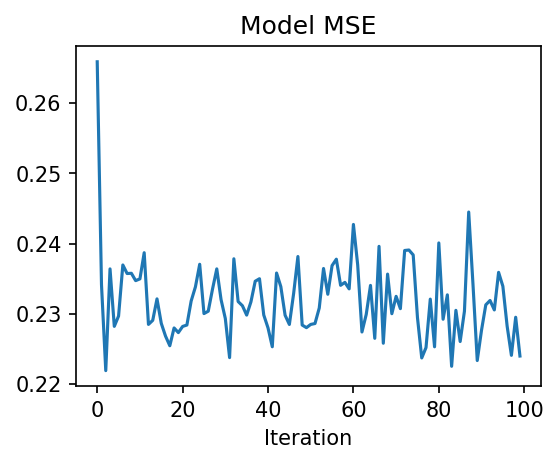

In [188]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(mse_history)
plt.title('Model MSE')
plt.xlabel('Iteration')
plt.show()

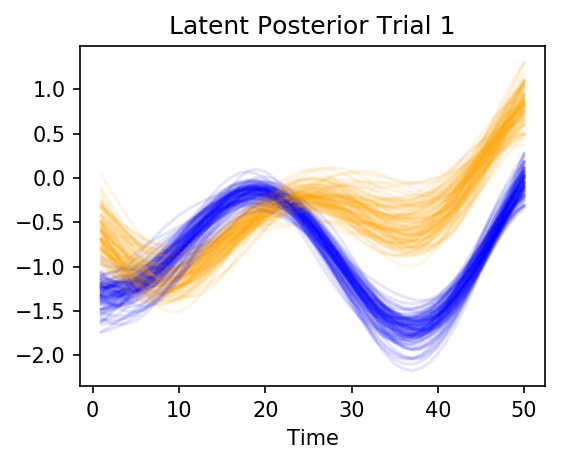

In [189]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(x, F_sample[i, :50, 0], color='orange', alpha=0.1)
    plt.plot(x, F_sample[i, :50, 1], color='blue', alpha=0.1)
plt.title('Latent Posterior Trial 1')
plt.xlabel('Time')
plt.show()

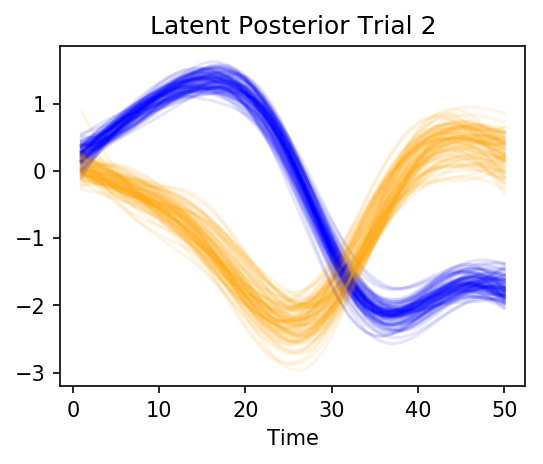

In [191]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(x, F_sample[i, 50:, 0], color='orange', alpha=0.1)
    plt.plot(x, F_sample[i, 50:, 1], color='blue', alpha=0.1)
plt.title('Latent Posterior Trial 2')
plt.xlabel('Time')
plt.show()

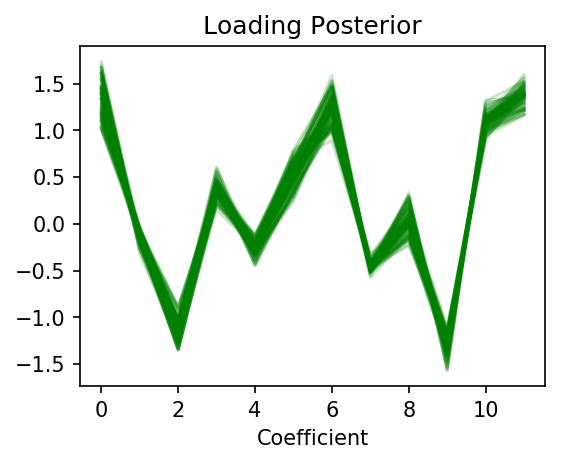

In [192]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(loading_sample[i].flatten(), alpha=0.2, color='green')
plt.title('Loading Posterior')
plt.xlabel('Coefficient')
plt.show()

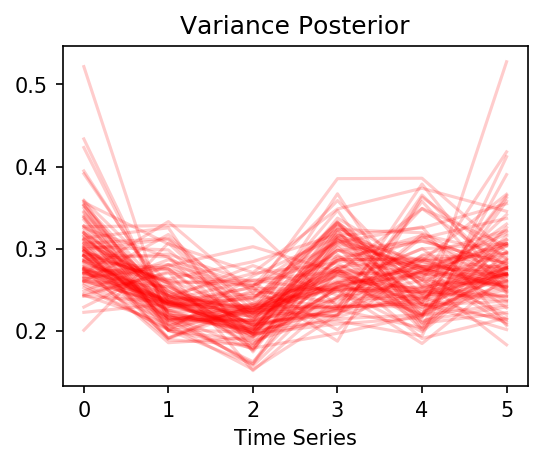

In [193]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(variance_sample[i], alpha=0.2, color='red')
plt.title('Variance Posterior')
plt.xlabel('Time Series')
plt.show()

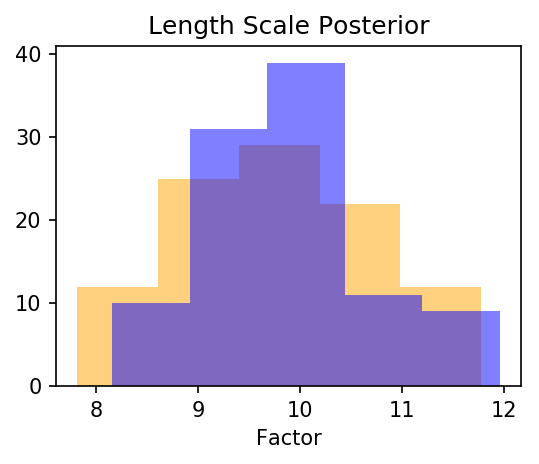

In [194]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.hist(theta_sample[:, 0], bins=5, alpha=0.5, color='orange')
plt.hist(theta_sample[:, 1], bins=5, alpha=0.5, color='blue')
plt.title('Length Scale Posterior')
plt.xlabel('Factor')
plt.show()

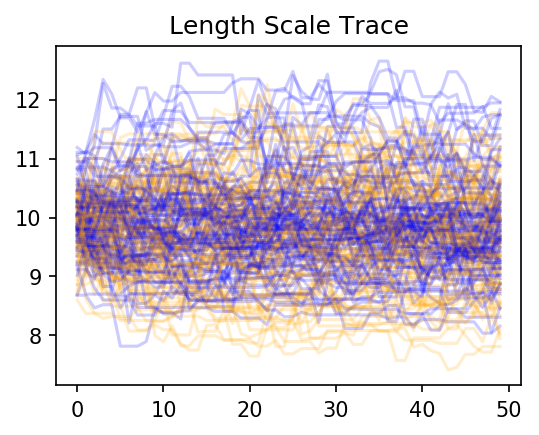

In [195]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(traces_hist[i, 0, :], alpha=0.2, color='orange')
    plt.plot(traces_hist[i, 1, :], alpha=0.2, color='blue')
plt.title('Length Scale Trace')
plt.show()